In [1]:
#Modules import
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from PIL import Image
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from torchvision.io import read_image
import numpy as np
import os

In [2]:
#Reading images names
files_images = "captcha_dataset/samples/"
names_images = os.listdir(files_images)
def_names_images = [name[:5] for name in names_images]

#dictionary for tokenizer
dico_idx_to_char = {}
dico_char_to_idx = {}
update_num = 0
for element in def_names_images:
    for el in element:
        if el not in dico_char_to_idx:
            dico_char_to_idx[el] = update_num
            dico_idx_to_char[update_num] = el
            update_num += 1

In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, images_name, img_dir, dico_char_to_idx, dico_idx_to_char):
        self.img_labels = images_name
        self.img_dir = img_dir
        self.dico_char_to_idx = dico_char_to_idx
        self.dico_idx_to_char = dico_idx_to_char
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        #transform to integer all character
        characters_label = self.img_labels[idx]
        label_value = [self.dico_char_to_idx[value] for value in characters_label if (value != "\n")]
        #if len(label_value) <longest_chaine:
        #    label_value = label_value + [dico_char_to_idx["unk"]]*(longest_chaine - len(label_value))
        label_value = torch.tensor(label_value)

        #transformation in one-hot
        #one_hot_values = torch.nn.functional.one_hot(label_value, 19)
        #load image
        img = Image.open(f"captcha_dataset/samples/{self.img_labels[idx]}.png").convert("RGB")
        #print(np.array(img).shape)
        image_tensor = ToTensor()(img)
        return image_tensor, label_value

In [ ]:
dataset = CustomImageDataset(def_names_images, "captcha_dataset/samples/", dico_char_to_idx, dico_idx_to_char)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

#test_dataset = CustomImageDataset(def_names_images, "captcha_dataset/samples/", dico_char_to_idx, dico_idx_to_char)

In [5]:
#model

class NeuralNetwork(nn.Module):
    def __init__(self, ch_1 = 46, ch_2 = 16, maxp_1 = 6, maxp_2 = 4, kernel = 3):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, ch_1, kernel, padding = "same"),
            nn.MaxPool2d(maxp_1),
            nn.Conv2d(ch_1, ch_2, kernel, padding="same"),
            nn.MaxPool2d(maxp_2),
            nn.Flatten()
        )
        self.MLP_1 = nn.Sequential(
            nn.Linear(((((50)//maxp_1))//maxp_2) * ((((200)//maxp_1))//maxp_2) * ch_2, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 19),
            #nn.Softmax()
        )

        self.MLP_2 = nn.Sequential(
            nn.Linear(((((50)//maxp_1))//maxp_2) * ((((200)//maxp_1))//maxp_2) * ch_2, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 19),
            #nn.Softmax()
        )

        self.MLP_3 = nn.Sequential(
            nn.Linear(((((50)//maxp_1))//maxp_2) * ((((200)//maxp_1))//maxp_2) * ch_2, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 19),
            #nn.Softmax()
        )

        self.MLP_4 = nn.Sequential(
            nn.Linear(((((50)//maxp_1))//maxp_2) * ((((200)//maxp_1))//maxp_2) * ch_2, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 19),
            #nn.Softmax()
        )

        self.MLP_5 = nn.Sequential(
            nn.Linear(((((50)//maxp_1))//maxp_2) * ((((200)//maxp_1))//maxp_2) * ch_2, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 19),
            #nn.Softmax()
        )

    def forward(self, x):
        x = self.conv(x)
        output_1 = self.MLP_1(x)
        output_2 = self.MLP_2(x)
        output_3 = self.MLP_3(x)
        output_4 = self.MLP_4(x)
        output_5 = self.MLP_5(x)
        return torch.stack([output_1, output_2, output_3, output_4, output_5], dim=1)

In [7]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    loss_total = 0
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred.view(-1, 19), y.view(-1))
        loss_total += loss
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * 8 + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
        return loss_total/size
    
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    #correct /= size
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    return test_loss

In [9]:
#Hyperparameters
model = NeuralNetwork()
learning_rate = 1e-3
epochs = 1000

#loss function
loss_fn = nn.CrossEntropyLoss()
#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
table_loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    table_loss.append(train_loop(dataloader, model, loss_fn, optimizer).detach().numpy())
print("Done!")

Epoch 1
-------------------------------
loss: 2.945769  [    8/ 1039]
Epoch 2
-------------------------------
loss: 2.975107  [    8/ 1039]
Epoch 3
-------------------------------
loss: 2.924855  [    8/ 1039]
Epoch 4
-------------------------------
loss: 2.961555  [    8/ 1039]
Epoch 5
-------------------------------
loss: 2.956785  [    8/ 1039]
Epoch 6
-------------------------------
loss: 2.972265  [    8/ 1039]
Epoch 7
-------------------------------
loss: 2.937073  [    8/ 1039]
Epoch 8
-------------------------------
loss: 2.954845  [    8/ 1039]
Epoch 9
-------------------------------
loss: 2.924060  [    8/ 1039]
Epoch 10
-------------------------------
loss: 2.963615  [    8/ 1039]
Epoch 11
-------------------------------
loss: 2.918000  [    8/ 1039]
Epoch 12
-------------------------------
loss: 2.920655  [    8/ 1039]
Epoch 13
-------------------------------
loss: 2.950676  [    8/ 1039]
Epoch 14
-------------------------------
loss: 2.948486  [    8/ 1039]
Epoch 15
------

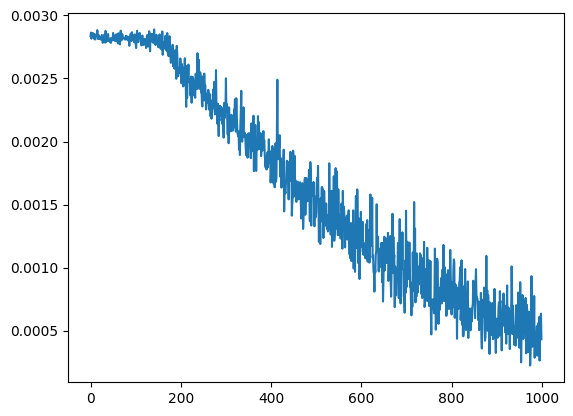

In [11]:
plt.plot(table_loss)

In [12]:
torch.max(model(dataset[20][0].reshape(1, 3, 50, 200)), dim = 2)

torch.return_types.max(
values=tensor([[ 4.6961,  5.7283,  3.8956,  8.6427, 13.0072]], grad_fn=<MaxBackward0>),
indices=tensor([[ 0, 18,  8,  0, 15]]))

In [15]:
dataset[20][1]

tensor([ 0, 18,  8,  0, 15])

In [1]:
import re

# Chaîne de test
chaine = "Exemple123.45, autre.test.string 89.abcd."

# Expression régulière pour récupérer les caractères alphanumériques avant un point
pattern = r'\b[a-zA-Z0-9]+(?=\.)'

# Recherche avec findall
resultat = re.findall(pattern, chaine)

print(resultat)


['Exemple123', 'autre', 'test', '89', 'abcd']
